In [1]:
# import ROOT
import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Agg') #CHANGES THE MATPLOTLIB BACKEND FOR LOOP PLOTS

import json
import sys

from ROOT import TCanvas, TH1F,TH2F,TH3F, TH1I, TFile,TLine,TGraph, TGraph2D, TGraphErrors, gStyle, THStack
from ROOT import TLatex, gPad, TLegend
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
# import tensorflow

sys.path.insert(1, '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share')
# sys.path.insert(1, '/eos/user/m/mhufnage/SWAN_projects/XTalk/')

from functionsHelper import *
# from helper_analysis import correctPhi


ModuleNotFoundError: No module named 'ROOT'

# Load datasets

In [2]:
# MC
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/file002.npz' 
# dataset     = np.load(filename,allow_pickle=True) # npz file contains arrays of dicts.

# Data
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/dataMinBias001.npz'
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/data_dataMinBias001.npz'
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/data_dataMinBias003.npz'
# dataset     = np.load(filename, allow_pickle=True)


# Helper
path        = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/EventReader/share/'
fDict       = open(path+'dictCaloByLayer.json')
caloDict    = json.load(fDict)

print("dataset loaded succesfully.")

dataset loaded succesfully.


# Function helpers

In [3]:
## HELPER FUNCTIONS

def correctPhi(phi):
    '''
    Return the corrected value of _phi, inside the [-Pi,+Pi] range.
    '''
    phi = round(phi, 4)
    if (phi) < ((-1)*math.pi):
        return round(((phi) + 2*math.pi), 4)
    elif (phi) > math.pi:
        return round(((phi) - 2*math.pi), 4)
    else:
        return round((phi), 4)
    
def getMatchedIndexes(theList, matchValue):
    matched_indexes = []
    i               = 0
    
    while i < len(theList):
        if matchValue == theList[i]:
            matched_indexes.append(i)
        i+=1
    return matched_indexes

def getCellsInWindow(cellEneList, 
                     cellIndexList, 
                     cellEtaList, 
                     cellPhiList, 
                     cellSamplingList, 
                     etaSize, 
                     phiSize, 
                     layer='EMB2',
                     fullCluster=False):
    ''' 
    Create a etaSize x PhiSize cell ROI 
    
    return the indexes of the array of cells. This array is composed of a sub-array of the cluster, with only the cells of the selected layer.
         window        : set of positional index inside sub-array, which belongs to the window
         layerIndexes  : array of indexes of all cells from chosen layer.'''
   
    # get the hot cell pos and value (for the layer)
    # layerIndexes    = np.where(cellSamplingList[0][:] == layer)[0]
    layerIndexes      = getMatchedIndexes(cellSamplingList[0], layer)
    
    if fullCluster == True:
        return layerIndexes
    
    # print(cellSamplingList[0][:], layerIndexes)
    if np.size( layerIndexes ) == 0:
        return [], []
    
    hotCellValue    = np.max(np.array(cellEneList[0])[layerIndexes])
    hotCellPos      = np.argmax(np.array(cellEneList[0])[layerIndexes])
    
    window          = [] # list of indexes of the cells inside the chosen window
    
    # find cells within limits of eta phi window
    # for sampling, ind, eta, phi in zip(cellSamplingList, cellIndexList[0], cellEtaList[0], cellPhiList[0]):
    for ind, eta, phi in zip(layerIndexes, np.array(cellEtaList[0])[layerIndexes], np.array(cellPhiList[0])[layerIndexes]):
        # print(cellEtaList[0][hotCellPos])
        # print (sampling)
        # if sampling == layer:
        etaConditionL    = eta >= (cellEtaList[0][hotCellPos] - etaSize/2)
        etaConditionR    = eta <= (cellEtaList[0][hotCellPos] + etaSize/2)
#         phiConditionU    = phi >= correctPhi( (cellPhiList[0][hotCellPos] - phiSize/2) )
#         phiConditionD    = phi <= correctPhi( (cellPhiList[0][hotCellPos] + phiSize/2) )
        lowerPhiRange    = cellPhiList[0][hotCellPos] - phiSize/2
        upperPhiRange    = cellPhiList[0][hotCellPos] + phiSize/2
        
        bPhiOverFlow = ( (lowerPhiRange < (-1)*math.pi) or (lowerPhiRange > 1*math.pi) or (upperPhiRange < (-1)*math.pi) or (upperPhiRange > 1*math.pi) )
            
            # if overflows, need to include the discontinuity in the middle of the interval.
        if bPhiOverFlow:
            phiCondition = (((phi >= correctPhi(lowerPhiRange)) and (phi <= 1*math.pi)) or ((phi <= correctPhi(upperPhiRange)) and (phi >= (-1)*math.pi)))
        else:
            phiCondition = ((phi >= lowerPhiRange) and (phi <= upperPhiRange))
        
        # print(etaConditionL,etaConditionR,phiConditionU,phiConditionD)
        
        if etaConditionL and etaConditionR and phiCondition:
            window.append( ind ) # add them to a list of index cells
            # print('window: ',window)
        

    return window, layerIndexes

def getSamplingGranularityFromDict(eta,caloDict, sampIndex):
    
    # Number of regions in each sampling layer (eta x phi region)
    regionsPerLayer = []
    for reg in caloDict['granularityEtaLayer']:
        regionsPerLayer.append(len(reg))
        
    for layerRegionIndex, etaMin, etaMax in zip(range(0,regionsPerLayer[sampIndex]), dictCaloLayer['etaLowLim'][sampIndex], dictCaloLayer['etaHighLim'][sampIndex]):    
        if ((abs(eta) > etaMin) and (abs(eta) < etaMax)):
            deta = caloDict['granularityEtaLayerPrecise'][sampIndex][layerRegionIndex]
            dphi = caloDict['granularityPhiLayerPrecise'][sampIndex][layerRegionIndex]
            return deta, dphi 


def getCellsInWindowCustomSize(
                     cellEneList, 
                     cellIndexList, 
                     cellEtaList, 
                     cellPhiList, 
                     cellSamplingList, 
                     nCellsEta, 
                     nCellsPhi, 
                     DEtaList,
                     DPhiList,
                     layer='EMB2',
                     fullCluster=False):
    ''' 
    Create a nCellsEta x nCellsPhi cell ROI.
    
    # Return the indexes of the array of cells. 
    # This array is composed of a sub-array of the cluster, with only the cells of the selected layer.
    # window        : set of positional index inside sub-array, which belongs to the window
    # layerIndexes  : array of indexes of all cells from chosen layer.'''
   
    # get the hot cell pos and value (for the layer)
    layerIndexes      = getMatchedIndexes(cellSamplingList[0], layer)
    
    if fullCluster == True:
        return layerIndexes

    if np.size( layerIndexes ) == 0:
        return [], []
    
    # determine the window size in eta x phi
    deta = np.max(np.array(DEtaList[0]))
    dphi = np.max(np.array(DPhiList[0]))
    
    etaSize = nCellsEta * deta
    phiSize = nCellsPhi * dphi
    
#     print(deta,etaSize,dphi,phiSize)
    
    hotCellValue    = np.max(np.array(cellEneList[0])[layerIndexes])
    hotCellPos      = np.argmax(np.array(cellEneList[0])[layerIndexes])
    
    window          = [] # list of indexes of the cells inside the chosen window
    
    # find cells within limits of eta phi window
    # for sampling, ind, eta, phi in zip(cellSamplingList, cellIndexList[0], cellEtaList[0], cellPhiList[0]):
    for ind, eta, phi in zip(layerIndexes, np.array(cellEtaList[0])[layerIndexes], np.array(cellPhiList[0])[layerIndexes]):
        etaConditionL    = eta >= (cellEtaList[0][hotCellPos] - etaSize/2)
        etaConditionR    = eta <= (cellEtaList[0][hotCellPos] + etaSize/2)
#         phiConditionU    = phi >= correctPhi( (cellPhiList[0][hotCellPos] - phiSize/2) )
#         phiConditionD    = phi <= correctPhi( (cellPhiList[0][hotCellPos] + phiSize/2) )
        
        lowerPhiRange    = cellPhiList[0][hotCellPos] - phiSize/2
        upperPhiRange    = cellPhiList[0][hotCellPos] + phiSize/2
        
        bPhiOverFlow = ( (lowerPhiRange < (-1)*math.pi) or (lowerPhiRange > 1*math.pi) or (upperPhiRange < (-1)*math.pi) or (upperPhiRange > 1*math.pi) )
            
            # if overflows, need to include the discontinuity in the middle of the interval.
        if bPhiOverFlow:
            phiCondition = (((phi >= correctPhi(lowerPhiRange)) and (phi <= 1*math.pi)) or ((phi <= correctPhi(upperPhiRange)) and (phi >= (-1)*math.pi)))
        else:
            phiCondition = ((phi >= lowerPhiRange) and (phi <= upperPhiRange))
        
        if etaConditionL and etaConditionR and phiCondition:
            window.append( ind ) # add them to a list of index cells
            if len(window) >= ( nCellsEta * nCellsPhi ):
                break
                

    return window, layerIndexes


def getNBinsSamplingCluster(eta, phi, sampl, clusterDict):
    '''
    Return the number of bins of TH2F for eta and phi,
    depending of the sampling.
    obs.: its a rough approximation, depending on the size of the cluster window eta-phi.
    '''
    layIdx          = getMatchedIndexes(clusterDict["Layer"], sampl)[0]
    # print(layIdx,np.shape(layIdx))
    lowEtaBounds    = clusterDict["etaLowLim"][layIdx]
    highEtaBounds   = clusterDict["etaHighLim"][layIdx]
    granEta         = clusterDict["granularityEtaLayerPrecise"][layIdx]
    granPhi         = clusterDict["granularityPhiLayerPrecise"][layIdx]
    
    etaGrid         = []
    phiGrid         = []
    
    #positive
    for stepEta, stepPhi, lowBound, highBound in zip(granEta, granPhi, lowEtaBounds, highEtaBounds):
        etaGrid.append( np.arange( lowBound, highBound, stepEta ) )
        phiGrid.append( np.arange( 0, math.pi, stepPhi ) )
    
    #add negative part to Eta/Phi
    fullEtaGrid = np.concatenate( (-1*np.flip(np.concatenate(etaGrid)[1:]), np.concatenate(etaGrid)), axis=0 )
    fullPhiGrid = np.concatenate( (-1*np.flip(np.concatenate(phiGrid)[1:]), np.concatenate(phiGrid)), axis=0 )
    
    #get NBins
    etaBins = 0
    phiBins = 0
    
    etaBins = ((np.min(eta) < fullEtaGrid) & (fullEtaGrid < np.max(eta))).sum() +1
    phiBins = ((np.min(phi) < fullPhiGrid) & (fullPhiGrid < np.max(phi))).sum() +1
    
    return int(etaBins), int(phiBins), fullEtaGrid, fullPhiGrid


## Loop over events and check them

In [4]:
# dataset['dataset'][0]['electrons']['el_0']['clusters']['cl_0']['channels']['digits']
el_thr           = 15 # GeV
nCellsChEta = 5
nCellsChPhi = 5
nCellsRawChEta = 5
nCellsRawChPhi = 5
fullSamplingPlot = False
# sampl = 'EMB2'

evtn       = 0
plots      = []
# clusSize   = {key:[] for key in caloDict["Layer"]}
# clusSizeCh = {key:[] for key in caloDict["Layer"]}
# clusSizeDigitsVsRawCh   = {"digits": {key:[] for key in caloDict["Layer"]}, "rawChannels":{key:[] for key in caloDict["Layer"]}}
analysis   = ['digitsClusterSize', 
              'digitsWindowSize',
              'channelEnergyCluster',
              'channelEnergyWindow',
              'channelTimeCluster',
              'channelTimeWindow', 
              'rawChClusterSize',
              'rawChWindowSize',
              'amplitudeCluster',
              'amplitudeWindow',
              'rawChTimeCluster',
              'rawChTimeWindow']
results    = {key:{key1:[] for key1 in analysis} for key in caloDict["Layer"]}

# only non-empty events
for ev in dataset['dataset']: # for each event...
    if (evtn%1000) == 0:
        print("Event {}...".format(evtn))
        
#     tempClusSizeCh = {key:[] for key in caloDict["Layer"]}
#     tempClusSize   = {key:[] for key in caloDict["Layer"]}
#     tempClusSizeDigits   = {key:[] for key in caloDict["Layer"]}
#     tempClusSizeRawCh   = {key:[] for key in caloDict["Layer"]}

#     if evtn > 50:
#         break
    for elec in ev['electrons'].keys(): # for each electron in this event...
#         print(ev['electrons'][elec]['pt'])
        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            continue
        if np.abs(ev['electrons'][elec]['eta']) > 1.4:
            continue
        for clus in ev['electrons'][elec]['clusters'].keys(): # for each cluster associated to that electron...
             
            for layIndex, sampl in enumerate(caloDict["Layer"]):
                  ###################
                  ## Channel + Digits
                  ###################
                layerIndexes = getMatchedIndexes(ev['electrons'][elec]['clusters'][clus]['channels']['sampling'][0], sampl)
                
                if len(layerIndexes) != 0:

                    windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                        ev['electrons'][elec]['clusters'][clus]['channels']['energy'],
                        ev['electrons'][elec]['clusters'][clus]['channels']['index'],
                        ev['electrons'][elec]['clusters'][clus]['channels']['eta'],
                        ev['electrons'][elec]['clusters'][clus]['channels']['phi'],
                        ev['electrons'][elec]['clusters'][clus]['channels']['sampling'],
                        nCellsChEta, 
                        nCellsChPhi, 
                        ev['electrons'][elec]['clusters'][clus]['channels']['deta'],
                        ev['electrons'][elec]['clusters'][clus]['channels']['dphi'],
                        layer=sampl)
                    
#                     print(windowIndexesCh , len(layerIndexesCh))
                  
                    digitsWindowSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[windowIndexesCh])
                    digitsClusterSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[layerIndexesCh])
                    channelEnergyCluster = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[layerIndexesCh]/1000
                    channelEnergyWindow = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[windowIndexesCh]/1000
                    channelTimeCluster = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['time'][0])[layerIndexesCh]
                    channelTimeWindow = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['time'][0])[windowIndexesCh]                    
                    
                    results[sampl]['digitsClusterSize'].append( digitsClusterSize )
                    results[sampl]['digitsWindowSize'].append( digitsWindowSize )
                    results[sampl]['channelEnergyCluster'].append( channelEnergyCluster.tolist() )
                    results[sampl]['channelEnergyWindow'].append( channelEnergyWindow.tolist() )
                    results[sampl]['channelTimeCluster'].append( channelTimeCluster.tolist() )
                    results[sampl]['channelTimeWindow'].append( channelTimeWindow.tolist() )
                  
                  
                ###############
                ## RawChannel #
                ###############
                layerIndexes = getMatchedIndexes(ev['electrons'][elec]['clusters'][clus]['rawChannels']['sampling'][0], sampl)
                
                if len(layerIndexes) != 0:
                
                    windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'],
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['index'],
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['eta'],
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['phi'],
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['sampling'],
                        nCellsRawChEta, 
                        nCellsRawChPhi, 
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['deta'],
                        ev['electrons'][elec]['clusters'][clus]['rawChannels']['dphi'],
                        layer=sampl)

#                     print(len(windowIndexesRawCh), len(layerIndexesRawCh))

                    rawChClusterSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[layerIndexesRawCh])
                    rawChWindowSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[windowIndexesRawCh])
                    amplitudeCluster = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[layerIndexesRawCh]
                    amplitudeWindow = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[windowIndexesRawCh]                    
                    rawChTimeCluster = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['time'][0])[layerIndexesRawCh]
                    rawChTimeWindow = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[windowIndexesRawCh]                    
                    
#                     print(rawChClusterSize)
                    
                    results[sampl]['rawChClusterSize'].append( rawChClusterSize )
                    results[sampl]['rawChWindowSize'].append( rawChWindowSize )
                    results[sampl]['amplitudeCluster'].append( amplitudeCluster.tolist() )
                    results[sampl]['amplitudeWindow'].append( amplitudeWindow.tolist() )
                    results[sampl]['rawChTimeCluster'].append( rawChTimeCluster.tolist() )
                    results[sampl]['rawChTimeWindow'].append( rawChTimeWindow.tolist() )

#                 (sampl=='PreSamplerB') or (sampl=='EMB1') or (sampl=='EMB2') or (sampl=='EMB3') ) and 
#                 if len(layerIndexesCh) == 0:
#                 print(" layerIndexes size = 0 for {}".format(sampl))
#                 print(" ", ev['electrons'][elec]['clusters'][clus]['pt'], " " )
#                 print(np.array( ev['electrons'][elec]['clusters'][clus]['cells']['eta'][0]) [layerIndexes] )
#                     continue
    
#                 print(len(windowIndexesRawCh), len(layerIndexesRawCh))
#                 

                # Full cluster in each sampling
#                 etaLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['eta'][0])[layerIndexesCh]
#                 phiLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['phi'][0])[layerIndexesCh]
#                 eneLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[layerIndexesCh]/1000
#                 digitsColl    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[layerIndexesCh]
                
#                 etaLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['eta'][0])[layerIndexes]
#                 phiLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['phi'][0])[layerIndexes]
# #                 eneLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['energy'][0])[layerIndexes]/1000

#                 rawChAmpl    = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[layerIndexes]
                
#                 # reduced window at each sampling
#                 etaWindow   = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['eta'][0])[windowIndexesCh]
#                 phiWindow   = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['phi'][0])[windowIndexesCh]
#                 eneWindow    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[windowIndexesCh]/1000
                
#                 #####################
                
#                 # size of cluster
#                 tempClusSize[sampl].append(len(etaLayer))
#                 tempClusSizeDigits[sampl].append(len(digitsColl))
#                 tempClusSizeRawCh[sampl].append(len(rawChAmpl))

# #                 clusSize[sampl].append(len(etaLayer))
                
#                 if evtn < 0:
#                     # Get number of bins
#                     etabins, phibins, etaGrid, phiGrid = getNBinsSamplingCluster(etaLayer, phiLayer, sampl, caloDict)

#                     # Plot TH2F of cluster #
#                     c_cell =  TCanvas("Cells_Evt{}_{}".format(evtn,clus),"{}_ev{}_{}".format(sampl, evtn, clus),600,400)
#                     if fullSamplingPlot:
#                         hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),len(etaGrid),np.min(etaGrid),np.max(etaGrid),len(phiGrid),np.min(phiGrid),np.max(phiGrid))
#                     else:
#                         hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),etabins,np.min(etaLayer),np.max(etaLayer),phibins,np.min(phiLayer),np.max(phiLayer))
#                     hist_clus.SetTitle("Zee;#eta;#phi;E_{T} [GeV]")

#                     for ind,index in enumerate(etaLayer):
#                         hist_clus.Fill(etaLayer[ind],phiLayer[ind],eneLayer[ind])

#                     hist_clus.Draw("LEGO2")    

#                     c_cell.Draw()
#                     c_cell.Print("Plots/{}_ev{}_{}.png".format(sampl, evtn, clus))
#                 ####################
#     for key in clusSize.keys():
#         clusSize[key].append(sum(tempClusSize[key]))
#         clusSizeDigitsVsRawCh["digits"][key].append(sum(tempClusSizeDigits[key]))
#         clusSizeDigitsVsRawCh["rawChannels"][key].append(sum(tempClusSizeRawCh[key]))
    evtn+=1 

Event 0...
Event 1000...


/tmp/ipykernel_621/2080760005.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digitsWindowSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[windowIndexesCh])
/tmp/ipykernel_621/2080760005.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digitsClusterSize = len(np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[layerIndexesCh])


Event 2000...
Event 3000...
Event 4000...
Event 5000...


# Cluster Size

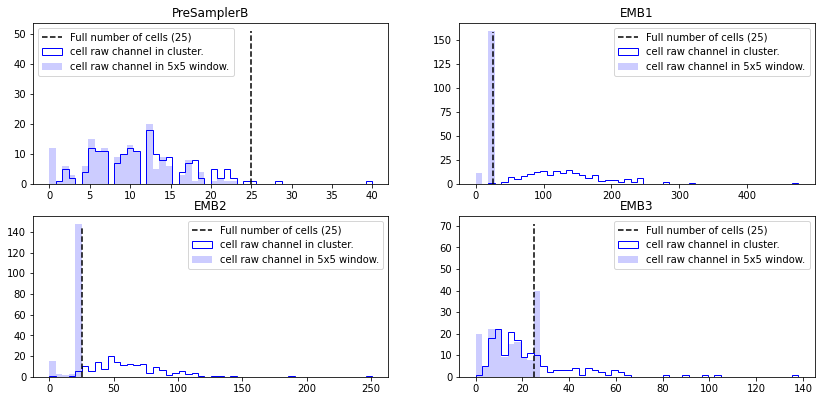

In [19]:
xbins = 50
plt.figure(figsize=(14,42))
# plt.suptitle("7x11 EMB2 ROI")
for i, sampl in enumerate( list(results.keys())[0:4] ):
    plt.subplot(12,2,i+1)
    minRange = 0
    maxRange = np.max(results[sampl]['rawChClusterSize'])
    countsCl, _ = np.histogram(results[sampl]['rawChClusterSize'])
    countsWi, _ = np.histogram(results[sampl]['rawChWindowSize'])

#     plt.hist(results[sampl]['digitsClusterSize'],bins=20,histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(results[sampl]['digitsWindowSize'],bins=20,alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
    plt.hist(results[sampl]['rawChClusterSize'],bins=xbins,range=(minRange,maxRange),histtype='step',color='blue', label='cell raw channel in cluster.')
    plt.hist(results[sampl]['rawChWindowSize'],bins=xbins,range=(minRange,maxRange),alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
    plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))

    plt.legend()
    plt.title(sampl)
#     plt.xscale('log')
#     plt.yscale('log')

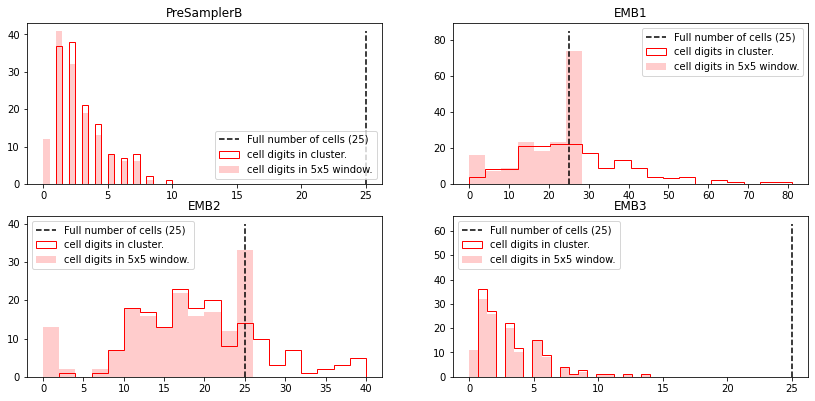

In [20]:
plt.figure(figsize=(14,42))
for i, sampl in enumerate( list(results.keys())[0:4] ):
    plt.subplot(12,2,i+1)
    minRange = 0
    maxRange = np.max(results[sampl]['digitsClusterSize'])
    countsCl, _ = np.histogram(results[sampl]['digitsClusterSize'])
    countsWi, _ = np.histogram(results[sampl]['digitsWindowSize'])

    plt.hist(results[sampl]['digitsClusterSize'],bins=20,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
    plt.hist(results[sampl]['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
    plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
#     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
#     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
    plt.legend()
    plt.title(sampl)
#     plt.yscale('log')

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/co

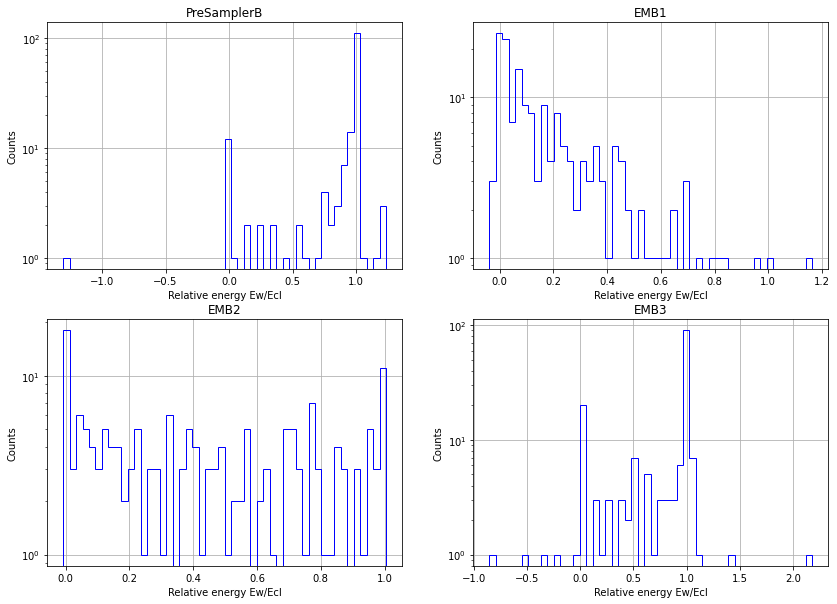

In [21]:


plt.figure(figsize=(14,10))
for i, sampl in enumerate( list(results.keys())[0:4] ):
    eneInClus = []
    eneInWin = []
    xbins = 50

    for cells in results[sampl]['amplitudeCluster']:
        eneInClus.append(sum(cells))
    for cells in results[sampl]['amplitudeWindow']:
        eneInWin.append(sum(cells))
    plt.subplot(2,2,i+1)
    minRange = 0
    maxRange = np.max(results[sampl]['amplitudeCluster'])
    countsCl, binsCl = np.histogram(eneInClus)
    countsWi, binsWi = np.histogram(eneInWin)
    
    plt.hist(np.array(eneInWin)/(np.array(eneInClus)),bins=xbins,histtype='step',color='blue', label='cell raw channel in cluster.')
#     plt.hist(countsWi/countsCl,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.plot(binsCl[:-1],countsWi/(countsCl+countsWi),'b*--')
#     plt.hist(eneInClus,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(eneInWin,bins=xbins,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#     plt.legend()
    plt.ylabel('Counts')
    plt.xlabel('Relative energy Ew/Ecl')
    plt.title(sampl)
    plt.grid()
    plt.yscale('log')
    
##############

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


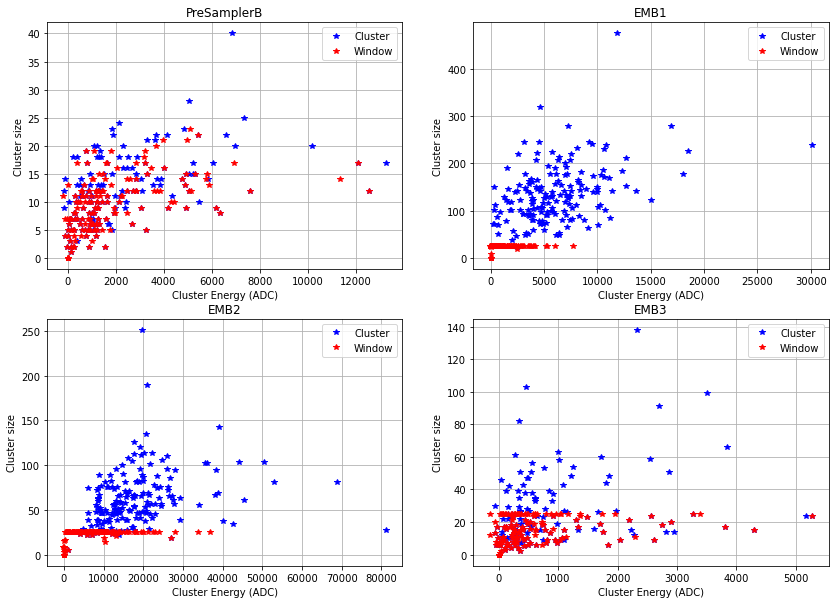

In [22]:

plt.figure(figsize=(14,10))
for i, sampl in enumerate( list(results.keys())[0:4] ):
    eneInClus = []
    eneInWin = []
    xbins = 50

    for cells in results[sampl]['amplitudeCluster']:
        eneInClus.append(sum(cells))
    for cells in results[sampl]['amplitudeWindow']:
        eneInWin.append(sum(cells))
        
    plt.subplot(2,2,i+1)
    minRange = 0
    maxRange = np.max(results[sampl]['amplitudeCluster'])
    countsCl, binsCl = np.histogram(eneInClus)
    countsWi, binsWi = np.histogram(eneInWin)
    
#     plt.hist(countsWi/countsCl,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
    plt.plot(eneInClus, results[sampl]['rawChClusterSize'],'b*',label='Cluster')
    plt.plot(eneInWin, results[sampl]['rawChWindowSize'],'r*',label='Window')
#     plt.hist(eneInClus,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(eneInWin,bins=xbins,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
    plt.legend()
    plt.xlabel('Cluster Energy (ADC)')
    plt.ylabel('Cluster size')
    plt.title(sampl)
    plt.grid()
#     plt.yscale('log')
    
##############

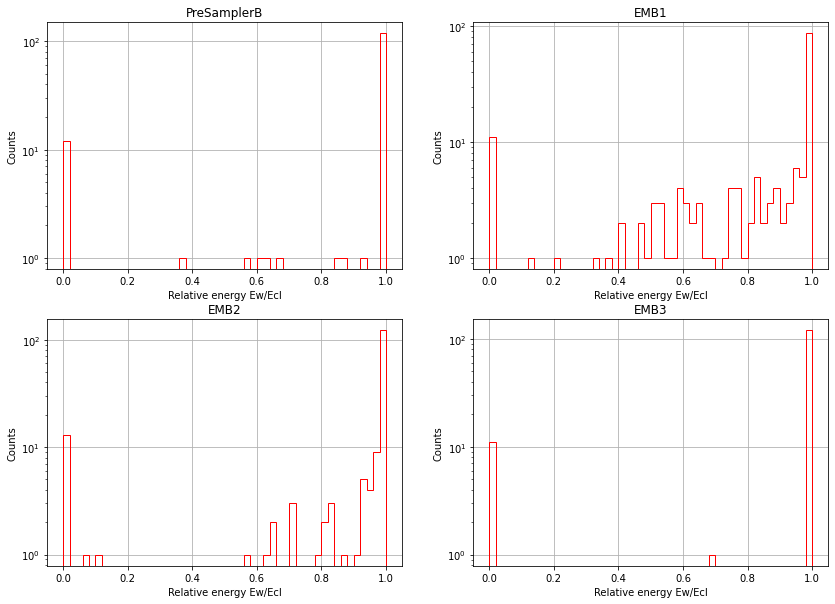

In [23]:


plt.figure(figsize=(14,10))
for i, sampl in enumerate( list(results.keys())[0:4] ):
    eneInClus = []
    eneInWin = []
    xbins = 50

    for cells in results[sampl]['channelEnergyCluster']:
        eneInClus.append(sum(cells))
    for cells in results[sampl]['channelEnergyWindow']:
        eneInWin.append(sum(cells))
        plt.subplot(2,2,i+1)
        minRange = 0
        maxRange = np.max(results[sampl]['digitsClusterSize'])
        countsCl, binsCl = np.histogram(eneInClus)
        countsWi, binsWi = np.histogram(eneInWin)
    
#     plt.hist(countsWi/countsCl,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.plot(binsCl[:-1],countsWi/(countsCl+countsWi),'r*--')
    plt.hist(np.array(eneInWin)/(np.array(eneInClus)),bins=xbins,histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(eneInClus,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(eneInWin,bins=xbins,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#     plt.legend()
    plt.ylabel('Counts')
    plt.xlabel('Relative energy Ew/Ecl')
    plt.title(sampl)
    plt.grid()
    plt.yscale('log')
    
##############

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


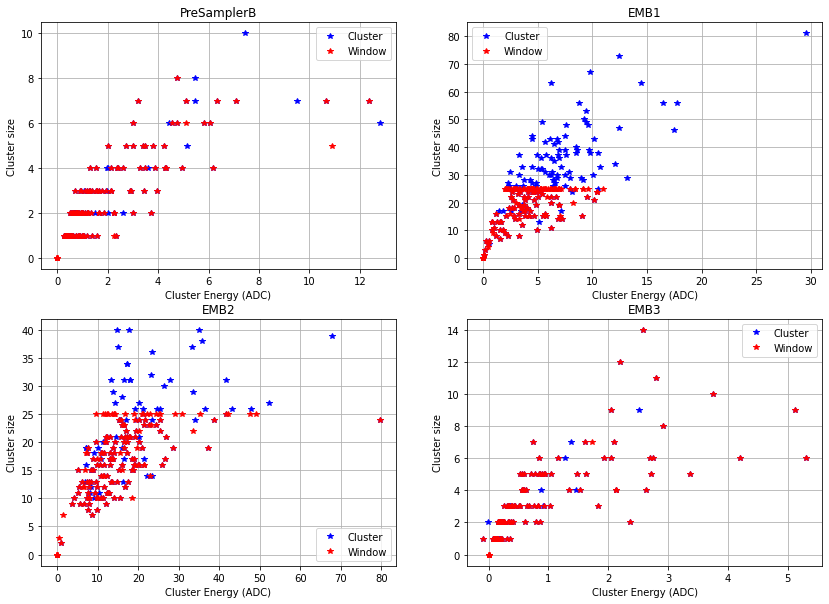

In [24]:

plt.figure(figsize=(14,10))
for i, sampl in enumerate( list(results.keys())[0:4] ):
    eneInClus = []
    eneInWin = []
    xbins = 50

    for cells in results[sampl]['channelEnergyCluster']:
        eneInClus.append(sum(cells))
    for cells in results[sampl]['channelEnergyWindow']:
        eneInWin.append(sum(cells))
        
    plt.subplot(2,2,i+1)
    minRange = 0
    maxRange = np.max(results[sampl]['channelEnergyCluster'])
    countsCl, binsCl = np.histogram(eneInClus)
    countsWi, binsWi = np.histogram(eneInWin)
    
#     plt.hist(countsWi/countsCl,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
    plt.plot(eneInClus, results[sampl]['digitsClusterSize'],'b*',label='Cluster')
    plt.plot(eneInWin, results[sampl]['digitsWindowSize'],'r*',label='Window')
#     plt.hist(eneInClus,bins=xbins,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
#     plt.hist(eneInWin,bins=xbins,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
    plt.legend()
    plt.xlabel('Cluster Energy (ADC)')
    plt.ylabel('Cluster size')
    plt.title(sampl)
    plt.grid()
#     plt.yscale('log')
    
##############

# Full data analysis: Digits vs RawChannels

In [6]:
# dataset['dataset'][0]['electrons']['el_0']['clusters']['cl_0']['channels']['digits']
# sampl = 'EMB2'
el_thr = 15 # GeV
nCellsChEta = 5
nCellsChPhi = 5
nCellsRawChEta = 5
nCellsRawChPhi = 5
datasetPath ='/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias/dataMinBias_part*.npz'
fullSamplingPlot = False

bClusterLoopOptions = [True, False] # change the cluster analysed in dumped data to 711_roi

timing               = {'clusters':{'channelTime':[]}, '711_roi':{'channelTime':[]}}

for bClusterLoop in bClusterLoopOptions:
       
        # to test clusters (true) or 711_roi (false)
    if bClusterLoop:
        clusName = 'clusters'
    else:
        clusName = '711_roi'
        
    evtn       = 0

    analysis   = ['digitsClusterSize', 
                  'digitsWindowSize',
                  'channelEnergyCluster',
                  'channelEnergyWindow',
                  'channelTimeCluster',
                  'channelTimeWindow', 
                  'rawChClusterSize',
                  'rawChWindowSize',
                  'amplitudeCluster',
                  'amplitudeWindow',
                  'rawChTimeCluster',
                  'rawChTimeWindow',                  
                  'channelInfoCluster',
                  'channelInfoWindow',
                  'rawChInfoCluster',
                  'rawChInfoWindow']
    results              = {key:{key1:[] for key1 in analysis} for key in caloDict["Layer"]}
    results[clusName]    = {'pt':[],'eta':[],'phi':[]} # Cluster and ROI data
    
    print(clusName,results[clusName], results.keys())
    
    fileNames    = glob(datasetPath)
    
    for file in fileNames:
        print(file)
        dataset     = np.load(file, allow_pickle=True)

        # only non-empty events
        for ev in dataset['dataset']: # for each event...
            if (evtn%1000) == 0:
                print("Event {}...".format(evtn))

        #     if evtn > 50:
        #         break
            for elec in ev['electrons'].keys(): # for each electron in this event...
        #         print(ev['electrons'][elec]['pt'])
                if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
                    continue
                if np.abs(ev['electrons'][elec]['eta']) > 1.4:
                    continue

                clusloop = ev['electrons'][elec][clusName]

                for clus in clusloop.keys(): # for each cluster associated to that electron...
        #         for clus in ev['electrons'][elec]['711_roi'].keys(): # for each cluster associated to that electron...

                    results[clusName]['pt'].append(ev['electrons'][elec][clusName][clus]['pt'])
                    results[clusName]['eta'].append(ev['electrons'][elec][clusName][clus]['eta'])
                    results[clusName]['phi'].append(ev['electrons'][elec][clusName][clus]['phi'])
                    
                    timing[clusName]['channelTime'].append(ev['electrons'][elec][clusName][clus]['channels']['time'][0])

                    for layIndex, sampl in enumerate(caloDict["Layer"]):
                          ###################
                          ## Channel + Digits
                          ###################
                        layerIndexes = getMatchedIndexes(ev['electrons'][elec]['clusters'][clus]['channels']['sampling'][0], sampl)

                        if len(layerIndexes) != 0:

                            windowIndexesCh, layerIndexesCh = getCellsInWindowCustomSize(
                                ev['electrons'][elec][clusName][clus]['channels']['energy'],
                                ev['electrons'][elec][clusName][clus]['channels']['index'],
                                ev['electrons'][elec][clusName][clus]['channels']['eta'],
                                ev['electrons'][elec][clusName][clus]['channels']['phi'],
                                ev['electrons'][elec][clusName][clus]['channels']['sampling'],
                                nCellsChEta, 
                                nCellsChPhi, 
                                ev['electrons'][elec][clusName][clus]['channels']['deta'],
                                ev['electrons'][elec][clusName][clus]['channels']['dphi'],
                                layer=sampl)

        #                     print(windowIndexesCh , len(layerIndexesCh))

                            digitsWindowSize = len(np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[windowIndexesCh])
                            digitsClusterSize = len(np.array(ev['electrons'][elec][clusName][clus]['channels']['digits'][0],dtype=object)[layerIndexesCh])
                            channelEnergyCluster = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)[layerIndexesCh]/1000
                            channelEnergyWindow = np.array(ev['electrons'][elec][clusName][clus]['channels']['energy'][0],dtype=object)[windowIndexesCh]/1000
                            channelTimeCluster = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)[layerIndexesCh]
                            channelTimeWindow = np.array(ev['electrons'][elec][clusName][clus]['channels']['time'][0],dtype=object)[windowIndexesCh]                            
                            channelInfoWin  = np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)[windowIndexesCh]
                            channelInfoClus = np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)[layerIndexesCh]

                            results[sampl]['digitsClusterSize'].append( digitsClusterSize )
                            results[sampl]['digitsWindowSize'].append( digitsWindowSize )
                            results[sampl]['channelEnergyCluster'].append( channelEnergyCluster.tolist() )
                            results[sampl]['channelEnergyWindow'].append( channelEnergyWindow.tolist() )
                            results[sampl]['channelTimeCluster'].append( channelTimeCluster.tolist() )
                            results[sampl]['channelTimeWindow'].append( channelTimeWindow.tolist() )
                            results[sampl]['channelInfoCluster'].append( channelInfoClus.tolist() ) # chInfo
                            results[sampl]['channelInfoWindow'].append( channelInfoWin.tolist() ) #chInfo


                        ###############
                        ## RawChannel #
                        ###############
                        layerIndexes = getMatchedIndexes(ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'][0], sampl)

                        if len(layerIndexes) != 0:

                            windowIndexesRawCh, layerIndexesRawCh = getCellsInWindowCustomSize(
                                ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'],
                                ev['electrons'][elec][clusName][clus]['rawChannels']['index'],
                                ev['electrons'][elec][clusName][clus]['rawChannels']['eta'],
                                ev['electrons'][elec][clusName][clus]['rawChannels']['phi'],
                                ev['electrons'][elec][clusName][clus]['rawChannels']['sampling'],
                                nCellsRawChEta, 
                                nCellsRawChPhi, 
                                ev['electrons'][elec][clusName][clus]['rawChannels']['deta'],
                                ev['electrons'][elec][clusName][clus]['rawChannels']['dphi'],
                                layer=sampl)

        #                     print(len(windowIndexesRawCh), len(layerIndexesRawCh))

                            rawChClusterSize = len(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[layerIndexesRawCh])
                            rawChWindowSize = len(np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh])
                            amplitudeCluster = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[layerIndexesRawCh]
                            amplitudeWindow = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh]                    
                            rawChTimeCluster = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['time'][0],dtype=object)[layerIndexesRawCh]
                            rawChTimeWindow = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['amplitude'][0],dtype=object)[windowIndexesRawCh]                            
                            rawChInfoWin  = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)[windowIndexesRawCh] #chInfo
                            rawChInfoClus = np.array(ev['electrons'][elec][clusName][clus]['rawChannels']['chInfo'][0],dtype=object)[layerIndexesRawCh] #chInfo

        #                     print(rawChClusterSize)

                            results[sampl]['rawChClusterSize'].append( rawChClusterSize )
                            results[sampl]['rawChWindowSize'].append( rawChWindowSize )
                            results[sampl]['amplitudeCluster'].append( amplitudeCluster.tolist() )
                            results[sampl]['amplitudeWindow'].append( amplitudeWindow.tolist() )
                            results[sampl]['rawChTimeCluster'].append( rawChTimeCluster.tolist() )
                            results[sampl]['rawChTimeWindow'].append( rawChTimeWindow.tolist() )
                            results[sampl]['rawChInfoCluster'].append( rawChInfoClus.tolist() )
                            results[sampl]['rawChInfoWindow'].append( rawChInfoWin.tolist() )

            evtn+=1

    confDict = {
        'el_thr': el_thr,
        'nCellsChEta': nCellsChEta,
        'nCellsChPhi': nCellsChPhi,
        'nCellsRawChEta': nCellsRawChEta,
        'nCellsRawChPhi': nCellsRawChPhi,
        'datasetPath': datasetPath
    }
    
    print(results.keys())
    
    np.savez('channelTiming.npz',**timing)
    if bClusterLoop:
        np.savez('results_analysis_cluster.npz',**results)
        np.savez('conf_analysis_cluster.npz',confDict)
        
    else:
        np.savez('results_analysis_711roi.npz',**results)
        np.savez('conf_analysis_711.npz',confDict)

clusters {'pt': [], 'eta': [], 'phi': []} dict_keys(['PreSamplerB', 'EMB1', 'EMB2', 'EMB3', 'PreSamplerE', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1', 'HEC2', 'HEC3', 'Tile_LB_A', 'Tile_LB_BC', 'Tile_LB_D', 'Tile_Gap1_C10', 'Tile_Gap2_D4', 'Tile_Gap3_E', 'Tile_EB_A', 'Tile_EB_BC', 'Tile_EB_D', 'FCAL0', 'FCAL1', 'FCAL2', 'clusters'])
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias/dataMinBias_part0.npz
Event 0...
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias/dataMinBias_part1.npz
Event 1000...
/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/offline-ringer-dev/crosstalk/run/dataMinBias/dataMinBias_part29.npz
Event 2000...
dict_keys(['PreSamplerB', 'EMB1', 'EMB2', 'EMB3', 'PreSamplerE', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1', 'HEC2', 'HEC3', 'Tile_LB_A', 'Tile_LB_BC', 'Tile_LB_D', 'Tile_Gap1_C10', 'Tile_Gap2_D4', 'Tile_Gap3_E', 'Tile_EB_A', 'Tile_EB_BC', 'Tile_EB_D', 'FCAL0', 'FCAL1', 'FCAL

In [13]:
np.array(ev['electrons'][elec][clusName][clus]['channels']['chInfo'][0],dtype=object)

array([list([0, 1, 25, 9, 120]), list([0, 1, 25, 9, 59]),
       list([0, 1, 25, 9, 124]), list([0, 1, 25, 9, 125]),
       list([0, 1, 25, 9, 62]), list([0, 1, 25, 9, 63]),
       list([0, 1, 25, 12, 120]), list([0, 1, 25, 12, 121]),
       list([0, 1, 25, 12, 59]), list([0, 1, 25, 12, 116]),
       list([0, 1, 25, 12, 124]), list([0, 1, 25, 12, 125]),
       list([0, 1, 25, 12, 62]), list([0, 1, 25, 12, 55]),
       list([0, 1, 25, 12, 63]), list([0, 1, 25, 13, 64]),
       list([0, 1, 25, 13, 65]), list([0, 51, 35, 1]),
       list([0, 51, 38, 1])], dtype=object)

In [17]:
np.array(ev['electrons'][elec][clusName][clus]['rawChannels'].keys())

array(dict_keys(['index', 'eta', 'phi', 'deta', 'dphi', 'caloRegion', 'sampling', 'amplitude', 'time', 'pedProv', 'quality']),
      dtype=object)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


455 358
457 455
458 458
447 361
455 358
457 455
458 458
447 361


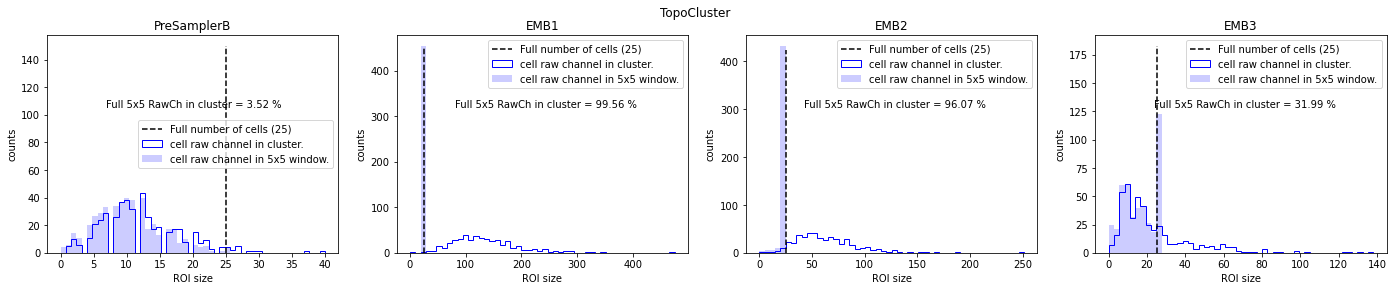

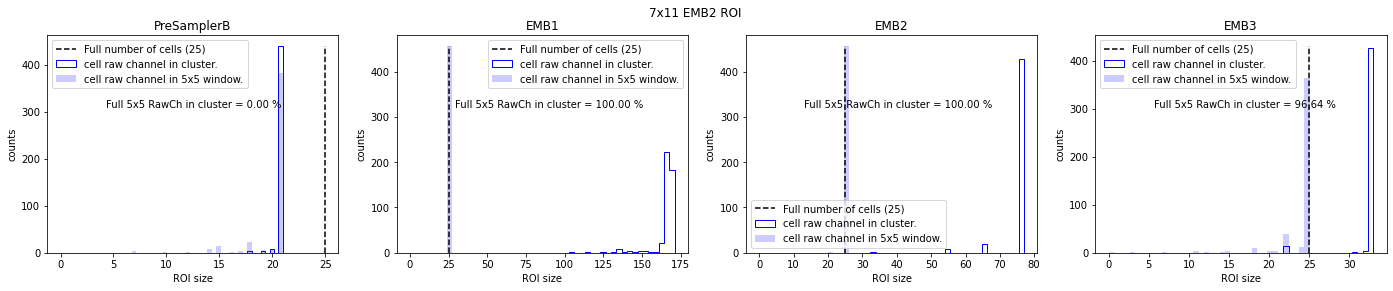

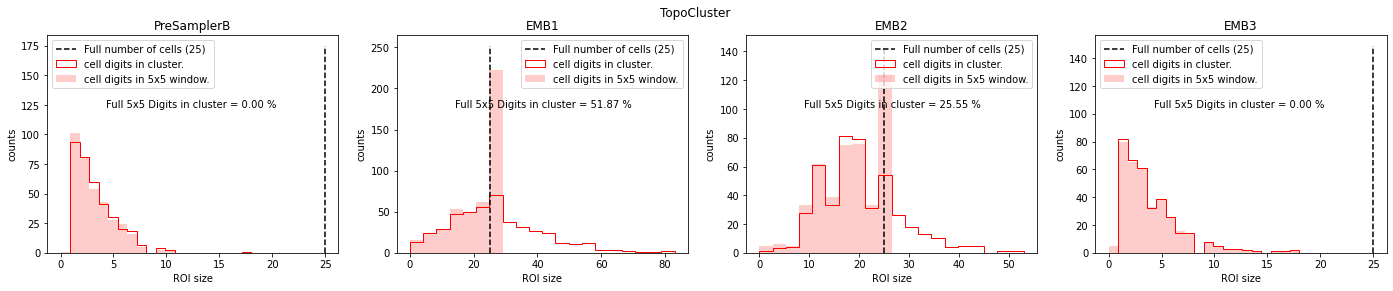

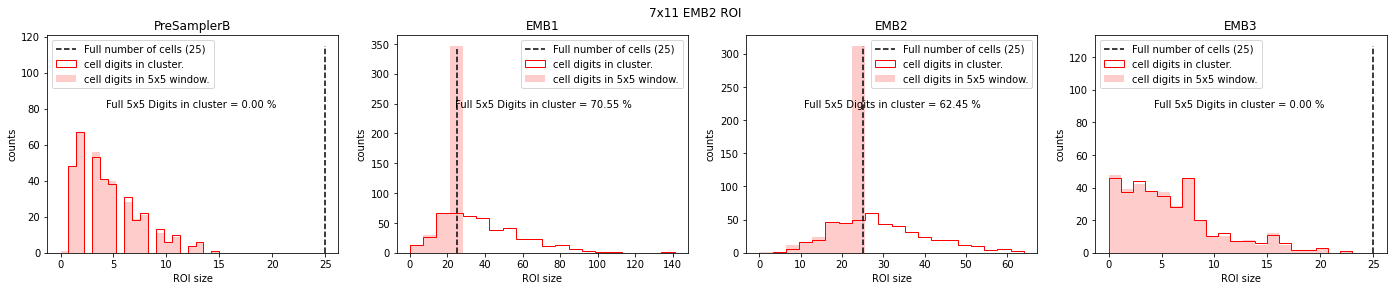

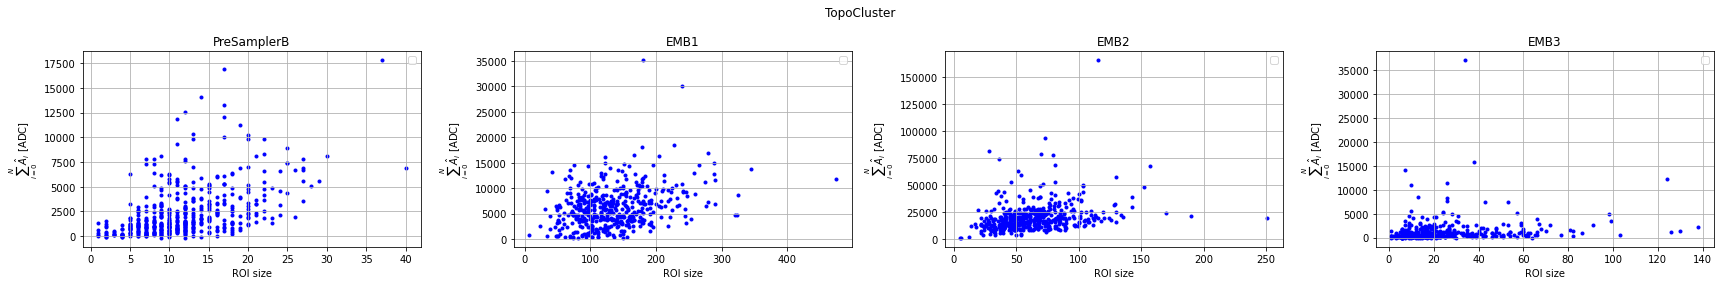

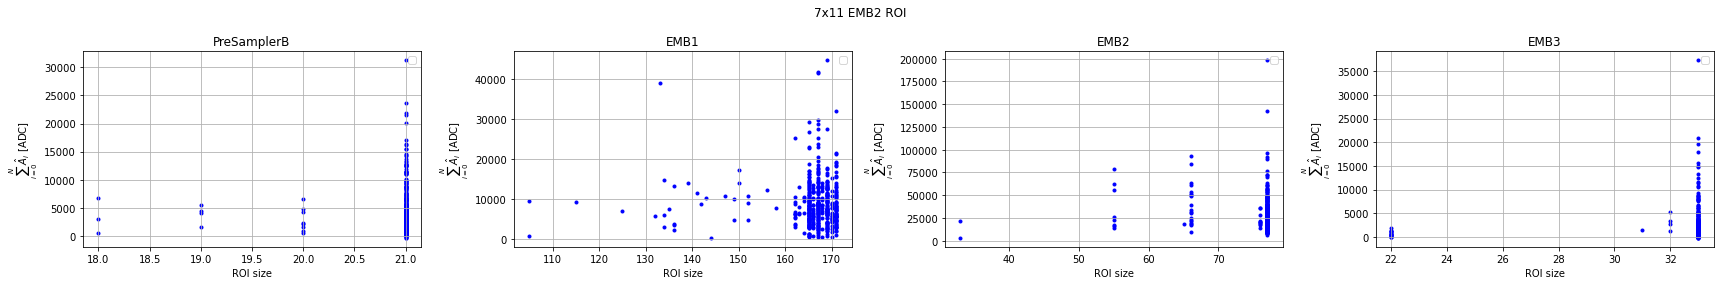

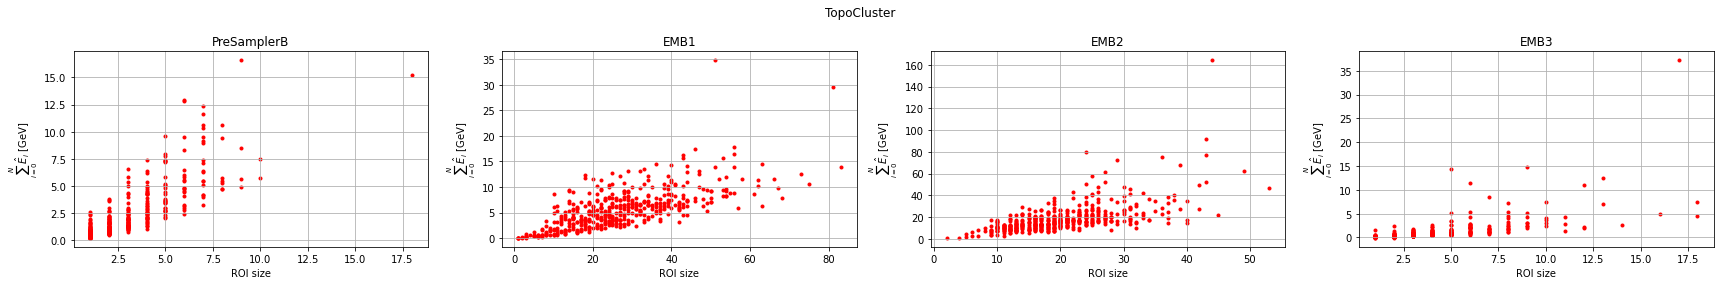

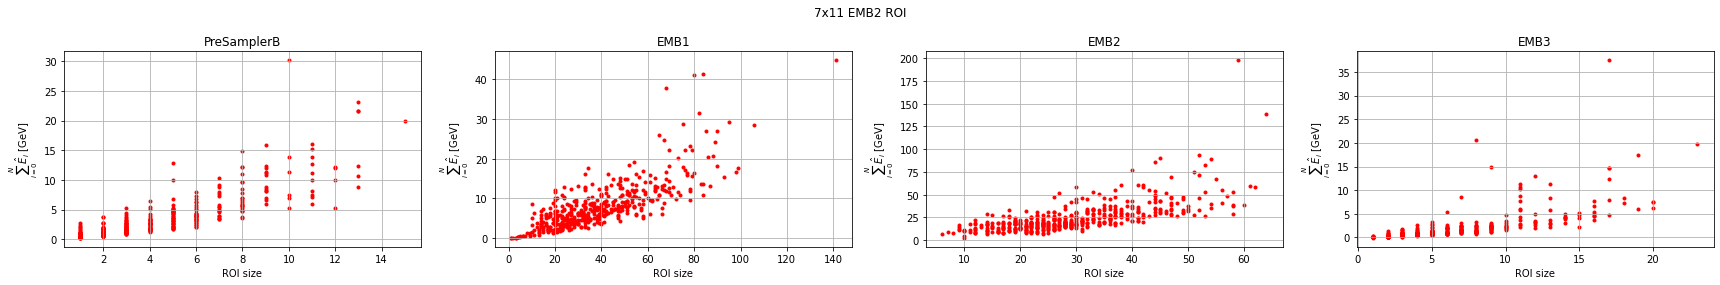

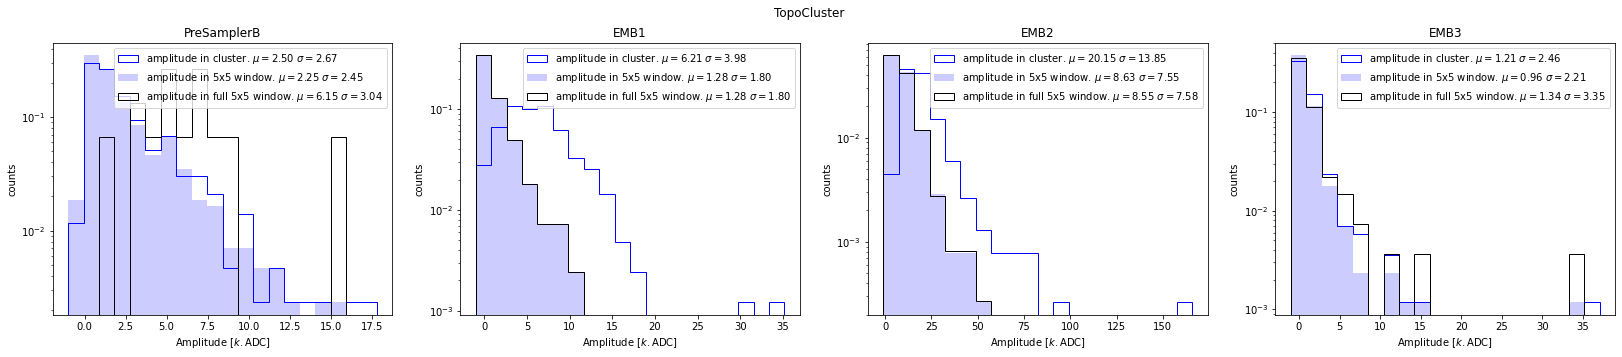

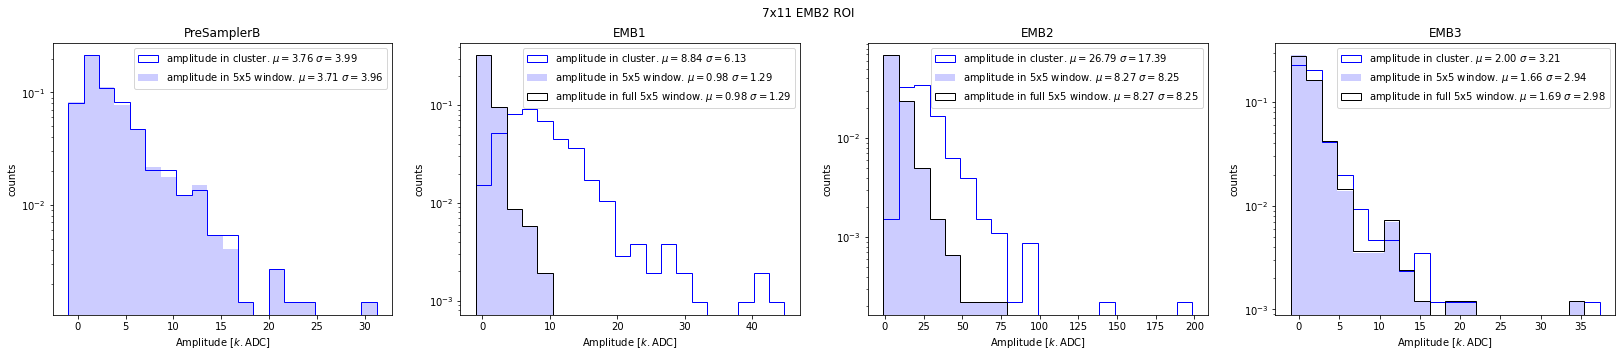

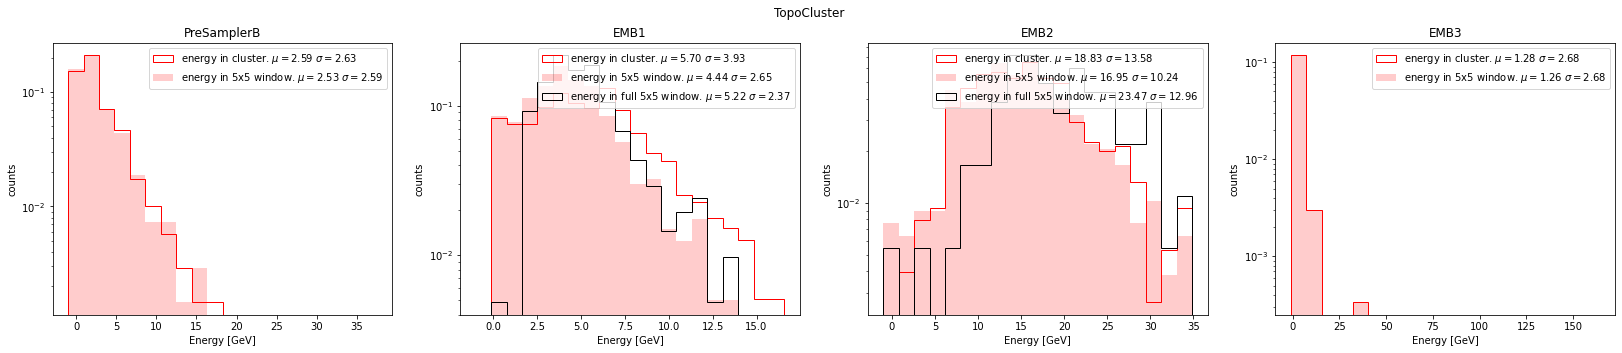

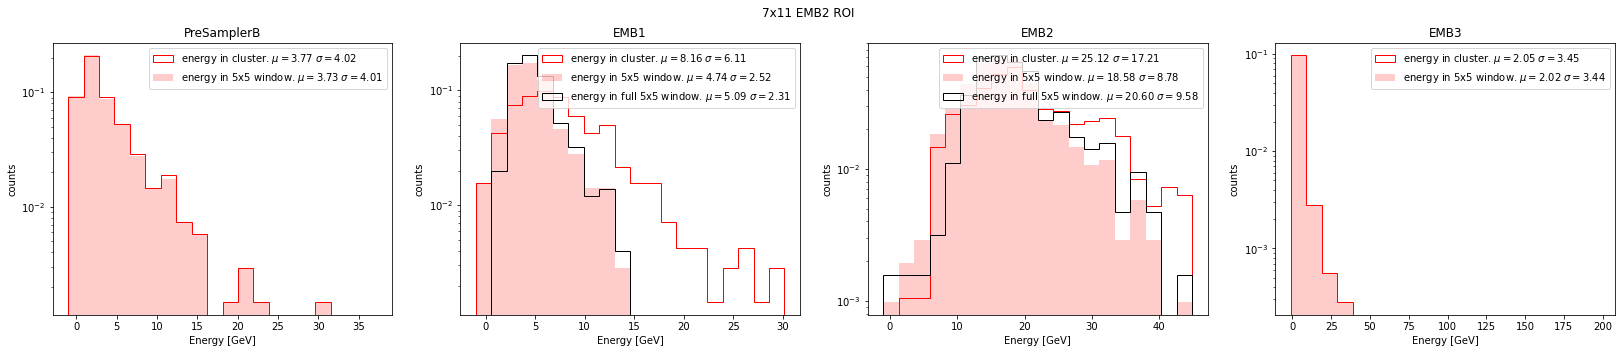

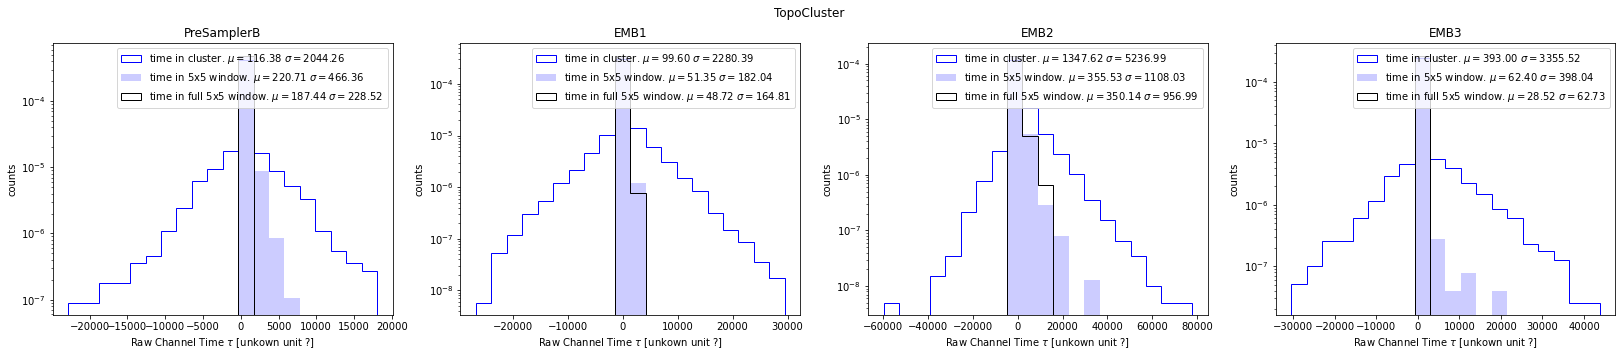

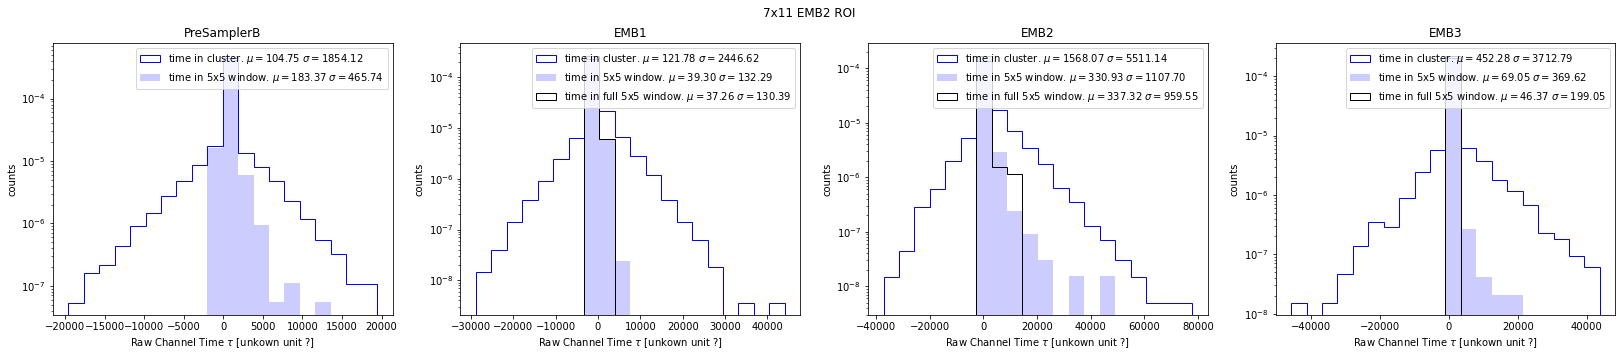

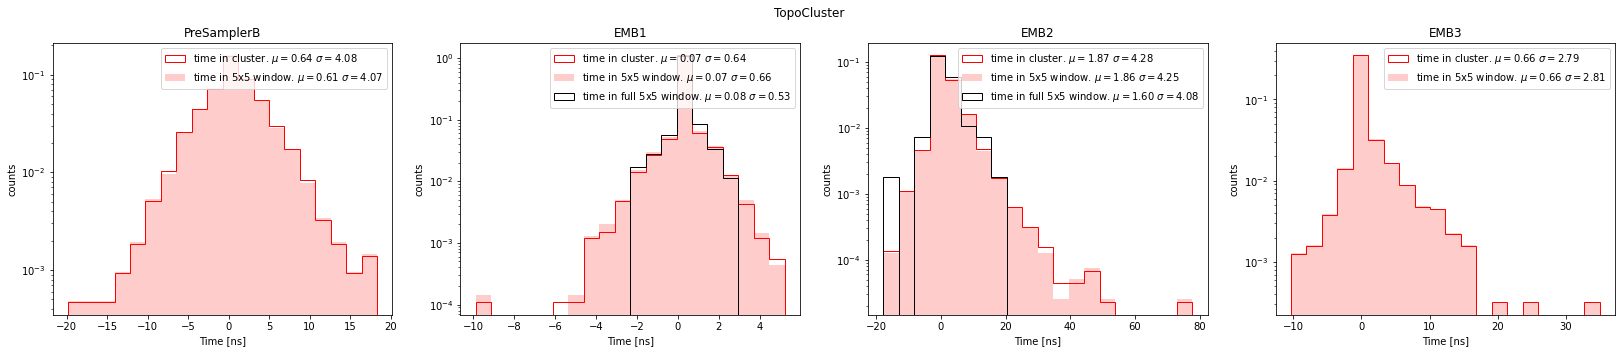

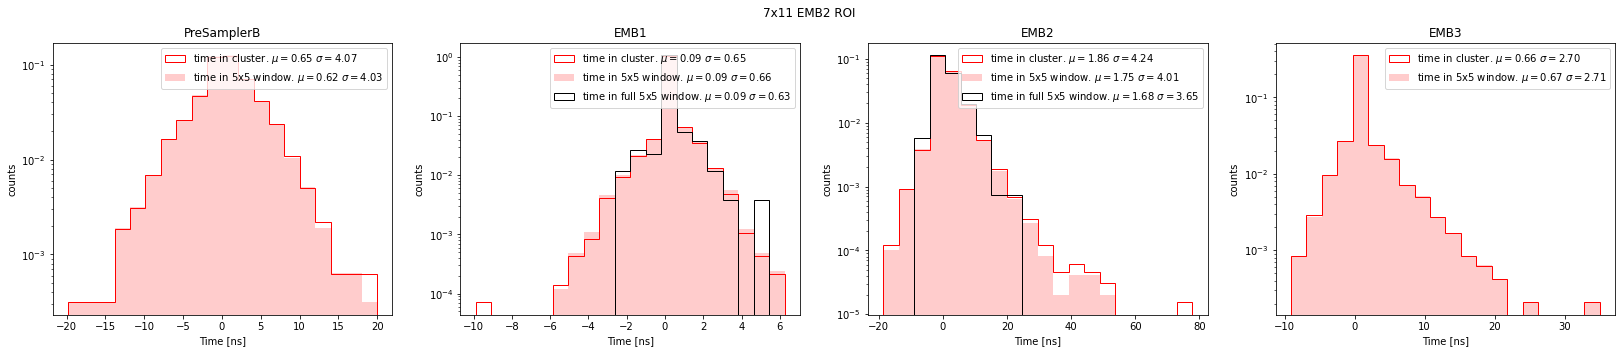

In [8]:
resultFiles = ['results_analysis_cluster.npz', 'results_analysis_711roi.npz']
supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
confFiles = ['conf_analysis_cluster.npz','conf_analysis_711.npz']
clusNames = ['clusters', '711_roi']


    # ---------------------------
    # RawChannel collection size
    # ---------------------------
    
for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    xbins = 50
    plt.figure(figsize=(24,4))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        minRange = 0
        maxRange = np.max(resultsInSampl['rawChClusterSize'])
        countsCl, _ = np.histogram(resultsInSampl['rawChClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['rawChWindowSize'])
        
        totalNumClusters = len(resultsInSampl['rawChClusterSize'])
        totalNumWindows  = len(resultsInSampl['rawChWindowSize'])
        nClusForANN = np.sum([k >= 25 for k in resultsInSampl['rawChClusterSize']])
        
#         print(totalNumClusters, totalNumWindows)

    #     plt.hist(results[sampl]['digitsClusterSize'],bins=20,histtype='step',color='red', label='cell digits in cluster.')
    #     plt.hist(results[sampl]['digitsWindowSize'],bins=20,alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
        plt.hist(resultsInSampl['rawChClusterSize'],bins=xbins,range=(minRange,maxRange),histtype='step',color='blue', label='cell raw channel in cluster.')
        plt.hist(resultsInSampl['rawChWindowSize'],bins=xbins,range=(minRange,maxRange),alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
        plt.text(0.2, 0.67, "Full %dx%d RawCh in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
        plt.legend()
        plt.title(sampl)
        plt.xlabel("ROI size")
        plt.ylabel("counts")
    #     plt.xscale('log')
    #     plt.yscale('log')

    # -----------------------
    # Digits collection size
    # -----------------------

for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    plt.figure(figsize=(24,4))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        minRange = 0
        maxRange = np.max(resultsInSampl['digitsClusterSize'])
        countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
        
        totalNumClusters = len(resultsInSampl['digitsClusterSize'])
        totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])

        plt.hist(resultsInSampl['digitsClusterSize'],bins=20,range=(minRange,maxRange),histtype='step',color='red', label='cell digits in cluster.')
        plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
        plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
        plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
    #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
    #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.legend()
        plt.title(sampl)
        plt.xlabel("ROI size")
        plt.ylabel("counts")
    #     plt.yscale('log')
    
    # -----------------------
    # RawChannel collection size
    #          vs
    # RawChannel Amplitude
    # -----------------------
for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    fig = plt.figure(figsize=(24,4))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        totalNumClusters = len(resultsInSampl['digitsClusterSize'])
        totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])
        ampInClus = [np.sum(k) for k in resultsInSampl['amplitudeCluster']]
        EneInClus = [np.sum(k) for k in resultsInSampl['channelEnergyCluster']]
        
        plt.subplot(1,4,i+1)
        plt.scatter(resultsInSampl['rawChClusterSize'],ampInClus, color='blue', marker='.')
#         plt.scatter(resultsInSampl['digitsClusterSize'],EneInClus, color='blue')
        plt.legend()
        plt.grid()
        plt.title(sampl)
        plt.xlabel("ROI size")
        plt.ylabel("$\sum_{i=0}^{N}\hat{A}_{i}$ [ADC]")
        fig.tight_layout()
    #     plt.yscale('log')
    
    # -----------------------
    # Digits collection size
    #          vs
    # Channel energy
    # -----------------------
for file, supTitle, confFile in zip(resultFiles, supTitleString, confFiles):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    fig = plt.figure(figsize=(24,4))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        totalNumClusters = len(resultsInSampl['digitsClusterSize'])
        totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])
        ampInClus = [np.sum(k) for k in resultsInSampl['amplitudeCluster']]
        EneInClus = [np.sum(k) for k in resultsInSampl['channelEnergyCluster']]
        print(len(ampInClus), len(EneInClus))
        
        plt.subplot(1,4,i+1)
#         plt.scatter(resultsInSampl['rawChClusterSize'],ampInClus, color='blue', marker='.')
        plt.scatter(resultsInSampl['digitsClusterSize'],EneInClus, color='red', marker='.')
#         plt.legend()
        plt.grid()
        plt.title(sampl)
        plt.xlabel("ROI size")
        plt.ylabel("$\sum_{i=0}^{N}\hat{E}_{i}$ [GeV]")
        fig.tight_layout()
    #     plt.yscale('log')
    
    
    # -----------------------
    # RawChannel Amplitude Cluster
    #          vs
    # RawChannel Amplitude Window
    # -----------------------    
for file, supTitle, confFile, clusName in zip(resultFiles, supTitleString, confFiles, clusNames):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    plt.figure(figsize=(28,5))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        
        ampInClus = [np.sum(k)/1000 for k in resultsInSampl['amplitudeCluster']]
        EneInClus = [np.sum(k) for k in resultsInSampl['channelEnergyCluster']]
        ampInWind = [np.sum(k)/1000 for k in resultsInSampl['amplitudeWindow']]
        EneInWind = [np.sum(k) for k in resultsInSampl['channelEnergyWindow']]
        
        minRange = -1
        maxRange = np.max(ampInClus)
        countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
        
        indexFullWindow =  np.where(np.array(resultsInSampl['rawChClusterSize']) >= (nCellsChEta*nCellsChPhi))
        
#         totalNumClusters = len(resultsInSampl['digitsClusterSize'])
#         totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
#         nClusForANN = np.sum([k >= 25 for k in resultsInSampl['digitsClusterSize']])

        plt.hist(ampInClus,bins=20,histtype='step', range=(minRange,maxRange), density=True, color='blue', label='amplitude in cluster. $\mu=${:.2f} $\sigma=${:.2f}'.format(np.mean(ampInClus), np.std(ampInClus)))
        plt.hist(ampInWind,bins=20,alpha=0.2,range=(minRange,maxRange), density=True, color='blue',label='amplitude in {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(ampInWind), np.std(ampInWind)))
        if len(indexFullWindow[0]) >0:
            plt.hist(np.array(ampInWind)[indexFullWindow],histtype='step',bins=20,range=(minRange,maxRange), density=True, color='black',label='amplitude in full {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(np.array(ampInWind)[indexFullWindow]), np.std(np.array(ampInWind)[indexFullWindow])))
#         plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#         plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
#         plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
    #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
    #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.legend()
        plt.title(sampl)
        plt.xlabel("Amplitude [$k.$ADC]")
        plt.ylabel("counts")
        plt.yscale('log')
        
    # -----------------------
    # Channel Energy Cluster
    #          vs
    # Channel Energy Amplitude Window
    # -----------------------    
    
for file, supTitle, confFile, clusName in zip(resultFiles, supTitleString, confFiles, clusNames):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    plt.figure(figsize=(28,5))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        minRange = -1
        maxRange = np.max(EneInClus)
        countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
        
        ampInClus = [np.sum(k)/1000 for k in resultsInSampl['amplitudeCluster']]
        EneInClus = [np.sum(k) for k in resultsInSampl['channelEnergyCluster']]
        ampInWind = [np.sum(k)/1000 for k in resultsInSampl['amplitudeWindow']]
        EneInWind = [np.sum(k) for k in resultsInSampl['channelEnergyWindow']]
        
#         totalNumClusters = len(resultsInSampl['digitsClusterSize'])
#         totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        indexFullWindow =  np.where(np.array(resultsInSampl['digitsClusterSize']) >= (nCellsChEta*nCellsChPhi))

        plt.hist(EneInClus,bins=20,histtype='step', range=(minRange,maxRange), density=True, color='red', label='energy in cluster. $\mu=${:.2f} $\sigma=${:.2f}'.format(np.mean(EneInClus), np.std(EneInClus)))
        plt.hist(EneInWind,bins=20,alpha=0.2,range=(minRange,maxRange), density=True, color='red',label='energy in {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(EneInWind), np.std(EneInWind)))
        if len(indexFullWindow[0]) >0:
            plt.hist(np.array(EneInWind)[indexFullWindow],histtype='step',bins=20,range=(minRange,maxRange), density=True, color='black',label='energy in full {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(np.array(EneInWind)[indexFullWindow]), np.std(np.array(EneInWind)[indexFullWindow])))
#         plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#         plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
#         plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
    #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
    #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.legend()
        plt.title(sampl)
        plt.xlabel("Energy [GeV]")
        plt.ylabel("counts")
        plt.yscale('log')
        
        
# -----------------------
# RawChannel Time Cluster
#          vs
# RawChannel Time  Window
# -----------------------    

for file, supTitle, confFile, clusName in zip(resultFiles, supTitleString, confFiles, clusNames):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    plt.figure(figsize=(28,5))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        
        RawChTimeInClus = [time for cluster in resultsInSampl['rawChTimeCluster'] for time in cluster]
        TimeInClus = [time for cluster in resultsInSampl['channelTimeCluster'] for time in cluster]
        RawChTimeInWind = [time for cluster in resultsInSampl['rawChTimeWindow'] for time in cluster]
        TimeInWind = [time for cluster in resultsInSampl['channelTimeWindow'] for time in cluster]
        
        minRange = np.min(RawChTimeInClus)
        maxRange = np.max(RawChTimeInClus)
        countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
        
#         totalNumClusters = len(resultsInSampl['digitsClusterSize'])
#         totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        indexFullWindow =  np.where(np.array(resultsInSampl['rawChClusterSize']) >= (nCellsChEta*nCellsChPhi))

        plt.hist(RawChTimeInClus,bins=20,histtype='step', range=(minRange,maxRange), density=True, color='blue', label='time in cluster. $\mu=${:.2f} $\sigma=${:.2f}'.format(np.mean(RawChTimeInClus), np.std(RawChTimeInClus)))
        plt.hist(RawChTimeInWind,bins=20,alpha=0.2,range=(minRange,maxRange), density=True, color='blue',label='time in {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(RawChTimeInWind), np.std(RawChTimeInWind)))
        if len(indexFullWindow[0]) >0:
            plt.hist(np.array(RawChTimeInWind)[indexFullWindow],histtype='step',bins=20,range=(minRange,maxRange), density=True, color='black',label='time in full {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(np.array(RawChTimeInWind)[indexFullWindow]), np.std(np.array(RawChTimeInWind)[indexFullWindow])))
#         plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#         plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
#         plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
    #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
    #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.legend()
        plt.title(sampl)
        plt.xlabel(r"Raw Channel Time $\tau$ [unkown unit ?]")
        plt.ylabel("counts")
        plt.yscale('log')
        

# -----------------------
# Channel Time Cluster
#          vs
# Channel Time  Window
# -----------------------    

for file, supTitle, confFile, clusName in zip(resultFiles, supTitleString, confFiles, clusNames):
    results     = np.load(file, allow_pickle=True)
    confDict    = np.load(confFile, allow_pickle=True)
    
    el_thr = confDict['arr_0'].tolist()['el_thr']
    nCellsChEta = confDict['arr_0'].tolist()['nCellsChEta']
    nCellsChPhi = confDict['arr_0'].tolist()['nCellsChPhi']
    nCellsRawChEta = confDict['arr_0'].tolist()['nCellsRawChEta']
    nCellsRawChPhi = confDict['arr_0'].tolist()['nCellsRawChPhi']
    
    plt.figure(figsize=(28,5))
    plt.suptitle(supTitle)
    for i, sampl in enumerate( list(results.keys())[0:4] ):
        resultsInSampl = results[sampl].tolist()
        
        plt.subplot(1,4,i+1)
        
#         RawChTimeInClus = [np.sum(k)/1000 for k in resultsInSampl['rawChTimeCluster']]
#         TimeInClus = [np.sum(k) for k in resultsInSampl['channelTimeCluster']]
#         RawChTimeInWind = [np.sum(k)/1000 for k in resultsInSampl['rawChTimeWindow']]
#         TimeInWind = [np.sum(k) for k in resultsInSampl['channelTimeWindow']]
        RawChTimeInClus = [time for cluster in resultsInSampl['rawChTimeCluster'] for time in cluster]
        TimeInClus = [time for cluster in resultsInSampl['channelTimeCluster'] for time in cluster]
        RawChTimeInWind = [time for cluster in resultsInSampl['rawChTimeWindow'] for time in cluster]
        TimeInWind = [time for cluster in resultsInSampl['channelTimeWindow'] for time in cluster]
        
        minRange = np.min(TimeInClus)
        maxRange = np.max(TimeInClus)
        countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
        countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])
        
#         totalNumClusters = len(resultsInSampl['digitsClusterSize'])
#         totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
        indexFullWindow =  np.where(np.array(resultsInSampl['digitsClusterSize']) >= (nCellsChEta*nCellsChPhi))

        plt.hist(TimeInClus,bins=20,histtype='step', range=(minRange,maxRange), density=True, color='red', label='time in cluster. $\mu=${:.2f} $\sigma=${:.2f}'.format(np.mean(TimeInClus), np.std(TimeInClus)))
        plt.hist(TimeInWind,bins=20,alpha=0.2,range=(minRange,maxRange), density=True, color='red',label='time in {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(TimeInWind), np.std(TimeInWind)))
        if len(indexFullWindow[0]) >0:
            plt.hist(np.array(TimeInWind)[indexFullWindow],histtype='step',bins=20,range=(minRange,maxRange), density=True, color='black',label='time in full {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(np.array(TimeInWind)[indexFullWindow]), np.std(np.array(TimeInWind)[indexFullWindow])))
#         plt.hist(resultsInSampl['digitsWindowSize'],bins=20,range=(minRange,maxRange),alpha=0.2,color='red', label='cell digits in {}x{} window.'.format(nCellsChEta,nCellsChPhi))
#         plt.plot([(nCellsRawChEta*nCellsRawChPhi), (nCellsRawChEta*nCellsRawChPhi)],[0,np.max([countsCl,countsWi])],'k--',label='Full number of cells ({})'.format(nCellsRawChEta*nCellsRawChPhi))
#         plt.text(0.2, 0.67, "Full %dx%d Digits in cluster = %.2f %%"%(nCellsChEta,nCellsChPhi,100*nClusForANN/totalNumClusters), transform=plt.gca().transAxes)
    #     plt.hist(results[sampl]['rawChClusterSize'],bins=20,histtype='step',color='blue', label='cell raw channel in cluster.')
    #     plt.hist(results[sampl]['rawChWindowSize'],bins=20,alpha=0.2,color='blue', label='cell raw channel in {}x{} window.'.format(nCellsRawChEta,nCellsRawChPhi))
        plt.legend()
        plt.title(sampl)
        plt.xlabel("Time [ns]")
        plt.ylabel("counts")
        plt.yscale('log')

# Single Cluster Timing Plot


In [5]:
# -----------------------
# < Single Cluster Timing Plot >
#
# Channel Time Cluster
#          vs
# Channel Time  Window
# -----------------------    

# resultFiles = ['results_analysis_cluster.npz', 'results_analysis_711roi.npz']
supTitleString = ['TopoCluster', '7x11 EMB2 ROI']
# confFiles = ['conf_analysis_cluster.npz','conf_analysis_711.npz']
clusNames = ['clusters', '711_roi']

results     = np.load('channelTiming.npz', allow_pickle=True)

for supTitle, clusName in zip(supTitleString, clusNames):
    
#     TimeInClus = [timeSingleCluster for timeSingleCluster in resultsInSampl['channelTimeCluster']]
#     TimeInWind = [timeSingleCluster for timeSingleCluster in resultsInSampl['channelTimeWindow']]
    
#     for sampl in  list(results.keys())[0:4]:
    resultsClus = results[clusName].tolist()
#         timeInAllSampling = []
#         timeInAllSampling.append(resultsInSampl['channelTimeCluster'])

    for i,TimeInClus in enumerate(resultsClus['channelTime']):

#             plt.figure(figsize=(28,5))
#             plt.suptitle(supTitle)
#         for i, sampl in enumerate( list(results.keys())[0:4] ):

#             plt.subplot(1,4,i+1)

#         RawChTimeInClus = [np.sum(k)/1000 for k in resultsInSampl['rawChTimeCluster']]
#         TimeInClus = [np.sum(k) for k in resultsInSampl['channelTimeCluster']]
#         RawChTimeInWind = [np.sum(k)/1000 for k in resultsInSampl['rawChTimeWindow']]
#         TimeInWind = [np.sum(k) for k in resultsInSampl['channelTimeWindow']]
#         RawChTimeInClus = [time for cluster in resultsInSampl['rawChTimeCluster'] for time in cluster]
#         RawChTimeInWind = [time for cluster in resultsInSampl['rawChTimeWindow'] for time in cluster]

#         minRange = np.min(TimeInClus)
#         maxRange = np.max(TimeInClus)
#         countsCl, _ = np.histogram(resultsInSampl['digitsClusterSize'])
#         countsWi, _ = np.histogram(resultsInSampl['digitsWindowSize'])

#         totalNumClusters = len(resultsInSampl['digitsClusterSize'])
#         totalNumWindows  = len(resultsInSampl['digitsWindowSize'])
#             indexFullWindow =  np.where(np.array(resultsInSampl['digitsClusterSize']) >= (nCellsChEta*nCellsChPhi))
        fig = plt.figure()
        plt.hist(TimeInClus,histtype='step', density=False, color='blue', label='time in cluster cells. $\mu=${:.2f} $\sigma=${:.2f}'.format(np.mean(TimeInClus), np.std(TimeInClus)))
#             plt.hist(TimeInWind,bins=20,alpha=0.2,range=(minRange,maxRange), density=True, color='red',label='time in {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(TimeInWind), np.std(TimeInWind)))
#             if len(indexFullWindow[0]) >0:
#                 plt.hist(np.array(TimeInWind)[indexFullWindow],histtype='step',bins=20,range=(minRange,maxRange), density=True, color='black',label='time in full {}x{} window. $\mu=${:.2f} $\sigma=${:.2f}'.format(nCellsChEta,nCellsChPhi,np.mean(np.array(TimeInWind)[indexFullWindow]), np.std(np.array(TimeInWind)[indexFullWindow])))
        plt.legend()
        plt.title(supTitle)
        plt.xlabel("Time [ns]")
        plt.ylabel("counts")
        plt.yscale('log')
#             plt.show()
        if len(TimeInClus) > 30:
            plt.savefig("Plots/clusterChannelTime_{}_{}.png".format(clusName,i))
        plt.close(fig)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_522/3334848141.py", line 61, in <module>
    plt.savefig("Plots/clusterChannelTime_{}_{}.png".format(clusName,i))
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/pyplot.py", line 966, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/figure.py", line 3015, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2255, in print_figure
    result = print_method(
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x

TypeError: object of type 'NoneType' has no len()

In [5]:
results     = np.load('channelTiming.npz', allow_pickle=True)

In [6]:
results[clusName].tolist()

{'channelTime': [[0.0,
   0.0,
   0.7582090497016907,
   0.0,
   0.0,
   -0.8688743710517883,
   1.9609953165054321,
   0.0,
   2.586266040802002,
   11.009103775024414,
   1.6206101179122925,
   8.568506240844727,
   0.0,
   0.0,
   1.0432919263839722,
   0.0,
   0.0,
   -5.693785667419434,
   3.2608680725097656],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.136628270149231,
   0.0,
   0.0,
   2.4045979976654053,
   0.0,
   0.0,
   -1.0819848775863647,
   0.0,
   0.0,
   0.0,
   4.278555393218994,
   9.48422908782959,
   0.0,
   0.40028485655784607,
   5.978775978088379,
   0.0,
   0.474093496799469,
   0.0,
   1.5288820266723633,
   2.0795395374298096,
   0.0,
   7.454777717590332,
   5.199430465698242,
   0.0,
   -1.008139967918396,
   0.0,
   0.0,
   13.3728666305542,
   -0.3052047789096832,
   0.0,
   0.0,
   0.0,
   1.9534485340118408,
   1.4919986724853516,
   -3.2959818840026855,
   -3.0201463699340

## - EM Clusters only

## Debug size of clusters

In [7]:
if datasetDict["dataset"]:
    print("not empty")
else:
    print("empty")

NameError: name 'datasetDict' is not defined

In [19]:
type(resultsInSampl)

list